references: 

ISLR chapter 2 on Bias Variance Tradeoff

URLs:

http://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/#overview

https://www.quantstart.com/articles/The-Bias-Variance-Tradeoff-in-Statistical-Machine-Learning-The-Regression-Setting/

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("CASP.csv")
df.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


In [5]:
df.shape

(45730, 10)

In [6]:
# shows there are no missing values
df.dropna().shape

(45730, 10)

In [7]:
train, test = train_test_split(df, test_size=0.1,random_state=0)

In [8]:
train.shape, test.shape

((41157, 10), (4573, 10))

In [9]:
X_test = test.drop(['F9'], axis=1) 
y_test = test['F9']

In [10]:
depth=2
k = 5
preds = []
for i in np.arange(k):
    # draw a training set from train portion
    ignore, training = train_test_split(train, test_size=0.3)
    X_training = training.drop(['F9'], axis=1) 
    y_training = training['F9']
    # fit a decision tree model using training set
    decision_tree = DecisionTreeRegressor(criterion='squared_error', max_depth=depth).fit(X_training, y_training)
    y_hat = decision_tree.predict(X_test)
    preds.append(y_hat) # each list element has the full set of predicted values for y_hat

In [11]:
y_hat.shape, y_test.shape, type(preds), preds[0].shape, len(preds)

((4573,), (4573,), list, (4573,), 5)

In [12]:
# k = len(preds)
pred_df = pd.DataFrame()
for i in np.arange(k):
#    print(i, preds[i].shape)
    pred_df = pd.concat([pred_df, pd.DataFrame(preds[i])], axis=1)

In [13]:
pred_df.shape

(4573, 5)

In [14]:
pred_df.head()

,0,0,0,0,0
0,35.205725,35.810099,35.840837,35.148516,35.215019
1,30.000201,30.494118,30.898251,29.665822,29.973245
2,40.351807,40.920273,40.865965,40.344012,40.384285
3,35.205725,35.810099,35.840837,35.148516,35.215019
4,35.205725,30.494118,30.898251,35.148516,35.215019


In [15]:
pred_df.iloc[0][:]

0    35.205725
0    35.810099
0    35.840837
0    35.148516
0    35.215019
Name: 0, dtype: float64

In [14]:
var = np.array([])
for i in np.arange(pred_df.shape[0]):
    var = np.append(var, np.var(pred_df.iloc[i][:]))

In [15]:
var.shape

(4573,)

In [16]:
np.mean(var)

0.9190565243804195

In [17]:
# create this piece of code as a function and repeatedly call it with varying level of depth

In [18]:
def calc_bias_variance_dtree(depth):
    k = 10
    preds = []
    pred_df = pd.DataFrame()
    for i in np.arange(k):
        # draw a training set from train portion
        _, training = train_test_split(train, test_size=0.3)
        X_training = training.drop(['F9'], axis=1) 
        y_training = training['F9']
        # fit a decision tree model using training set
        decision_tree = DecisionTreeRegressor(criterion='squared_error', max_depth=depth,random_state=0).fit(X_training, y_training)
        y_hat = decision_tree.predict(X_test)
        preds.append(y_hat)
        pred_df = pd.concat([pred_df, pd.DataFrame(preds[i])], axis=1)
    
    # calculate variance as the variance among the value for the same sample from various models bias
    var = np.array([])
    for i in np.arange(pred_df.shape[0]):
        var = np.append(var, np.var(pred_df.iloc[i][:]))

    # calculate bias, as the gap between truth and avg of predicted values
    # each row has k values predicted for the sample. get the mean of these columns. 
    # mean of squares of gap between that and true y.        
    pred_df['rowmean'] = pred_df.mean(axis=1) # row means i.e. E(yhat across models)
    gap = np.array(y_test) - np.array(pred_df.rowmean)
    
    return np.mean(var),np.mean(gap**2)

In [25]:
pred_df.mean(axis=1)

0       35.444039
1       30.206327
2       40.573269
3       35.444039
4       33.392326
          ...    
4568    30.206327
4569    40.573269
4570    30.206327
4571    35.444039
4572    40.573269
Length: 4573, dtype: float64

In [19]:
var_lst = []
bias_lst = []
depths = np.arange(start=2,stop=10,step=1)
for i in depths:
    depth = i+1
    var_lst.append(calc_bias_variance_dtree(depth)[0])
    bias_lst.append(calc_bias_variance_dtree(depth)[1])

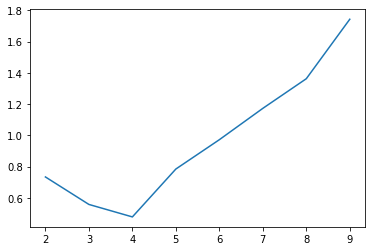

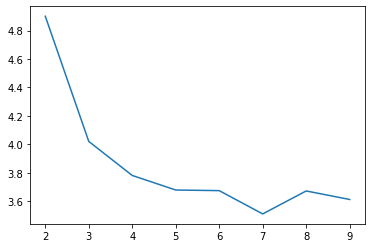

In [20]:
plt.plot(depths,var_lst)
plt.show()
plt.plot(depths,bias_lst)
plt.show()

In [21]:
def calc_bias_variance_lasso(alpha):
    k = 10
    preds = []
    pred_df = pd.DataFrame()
    for i in np.arange(k):
        # draw a training set from train portion
        _, training = train_test_split(train, test_size=0.3)
        X_training = training.drop(['F9'], axis=1) 
        y_training = training['F9']
        # fit a regression model using training set
        sample_lasso_model = Lasso(alpha=alpha, normalize=True)
        sample_lasso_model.fit(X_training,y_training)
        y_hat = sample_lasso_model.predict(X_test)
        preds.append(y_hat)
        pred_df = pd.concat([pred_df, pd.DataFrame(preds[i])], axis=1)
    
    var = np.array([])
    for i in np.arange(pred_df.shape[0]):
        var = np.append(var, np.var(pred_df.iloc[i][:]))
    
    pred_df['rowmean'] = pred_df.mean(axis=1)
    gap = np.array(y_test) - np.array(pred_df.rowmean)
    
    return np.mean(var),np.mean(gap**2)

In [22]:
var_lst = []
bias_lst = []
alphas = np.arange(start=0,stop=10,step=1)
for i in alphas:
    alpha = i
    var_lst.append(calc_bias_variance_lasso(alpha)[0])
    bias_lst.append(calc_bias_variance_lasso(alpha)[1])

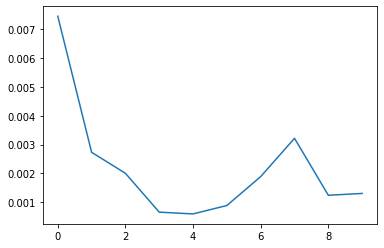

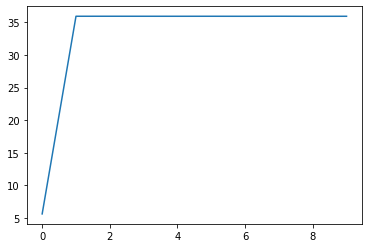

In [23]:
plt.plot(alphas,var_lst)
plt.show()
plt.plot(alphas,bias_lst)
plt.show()